In [1]:
# Variational Autoecoder

In [1]:
# Import the packages
import time
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

if torch.cuda.is_available():
    torch.backend.cudnn.deterministic = True

In [2]:
### Settings

# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device", device)

# Hyperparameters
random_seed = 0
learning_rate = 0.001
num_epochs = 50
batch_size = 128

# Architecture
num_features = 784
num_hidden_1 = 500
num_latent = 15

# MNIST dataset
train_set = datasets.MNIST(root='data',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

test_set = datasets.MNIST(root='data',
                         train=False,
                         transform= transforms.ToTensor())

train_loader = DataLoader(dataset=train_set,
                         batch_size=batch_size,
                         shuffle=True)
test_loader = DataLoader(dataset=test_set,
                        batch_size=batch_size,
                        shuffle=False)

# Check the dataset
for images, labels in train_loader:
    print("Image batch dimension",images.shape)
    print("Image labels dimension",labels.shape)
    break

device cpu
Image batch dimension torch.Size([128, 1, 28, 28])
Image labels dimension torch.Size([128])


In [10]:
### Model Architecture ###
class VariationalAutoencoder(torch.nn.Module):
    def __init__(self, num_features, num_hidden_1, num_latent):
        super(VariationalAutoencoder, self).__init__()
    
        ## Encoder ##
        self.hidden_1 = torch.nn.Linear(num_features, num_hidden_1)
        self.z_mean = torch.nn.Linear(num_hidden_1, num_latent)
        self.z_log_var = torch.nn.Linear(num_hidden_1, num_latent)
    
        ## Decoder ##
        self.linear_3 = torch.nn.Linear(num_latent, num_hidden_1)
        self.linear_4 = torch.nn.Linear(num_hidden_1, num_features)
    
    def reparameterize(self, z_mu, z_log_var):
        # sample epsilon from standard normal distribution
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(device)
        z = z_mu + eps * torch.exp(z_log_var/2)
        return z
    
    def encoder(self, features):
        x = self.hidden_1(features)
        x = F.leaky_relu(x, negative_slope=0.0001)
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return z_mean, z_log_var, encoded
    
    def decoder(self, encoded):
        x = self.linear_3(encoded)
        x = F.leaky_relu(x, negative_slope=0.0001)
        x = self.linear_4(x)
        decoded = torch.sigmoid(x)
        return decoded
    
    def forward(self, features):
        z_mean, z_log_var, encoded = self.encoder(features)
        decoded = self.decoder(encoded)
        
        return z_mean, z_log_var, encoded, decoded

torch.manual_seed(random_seed)
model = VariationalAutoencoder(num_features,
                              num_hidden_1,
                              num_latent)

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    
    

In [11]:
## Training ## 
start_time = time.time()
for epoch in range(num_epochs):
    for batch_idx, (features, target) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(device)
        
        # forward and back prop
        # forward prop computer the cost fucntion
        # back prop compute the gradient
        z_mean, z_log_var, encoded, decoded = model(features)
        # cost = reconstruction loss + kullback-leibler divergence
        kl_divergence = (0.5 * (z_mean**2 + 
                               torch.exp(z_log_var) - z_log_var - 1)).sum()
        pixelwise_bce = F.binary_cross_entropy(decoded, features, reduction='sum')
        cost = kl_divergence + pixelwise_bce
        
        optimizer.zero_grad()
        cost.backward()
        
        
        # updates the parameters
        optimizer.step()
        
        ## Logging
        if not batch_idx % 50:
            print('Epoch: %03d/%03d | Batch %03d/%03d | cost: %.4f'
                 %(epoch+1, num_epochs, batch_idx,
                  len(train_loader), cost))
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/050 | Batch 000/469 | cost: 70481.7266
Epoch: 001/050 | Batch 050/469 | cost: 27138.4414
Epoch: 001/050 | Batch 100/469 | cost: 22839.4844
Epoch: 001/050 | Batch 150/469 | cost: 19487.9023
Epoch: 001/050 | Batch 200/469 | cost: 18688.1484
Epoch: 001/050 | Batch 250/469 | cost: 18047.5430
Epoch: 001/050 | Batch 300/469 | cost: 16600.3203
Epoch: 001/050 | Batch 350/469 | cost: 17130.8398
Epoch: 001/050 | Batch 400/469 | cost: 16406.1719
Epoch: 001/050 | Batch 450/469 | cost: 16029.9385
Time elapsed: 0.33 min
Epoch: 002/050 | Batch 000/469 | cost: 16585.7422
Epoch: 002/050 | Batch 050/469 | cost: 15473.1055
Epoch: 002/050 | Batch 100/469 | cost: 15651.4453
Epoch: 002/050 | Batch 150/469 | cost: 15746.6318
Epoch: 002/050 | Batch 200/469 | cost: 15129.7373
Epoch: 002/050 | Batch 250/469 | cost: 15285.8672
Epoch: 002/050 | Batch 300/469 | cost: 15431.5146
Epoch: 002/050 | Batch 350/469 | cost: 15656.5449
Epoch: 002/050 | Batch 400/469 | cost: 14752.6299
Epoch: 002/050 | Batch 450/

Epoch: 016/050 | Batch 350/469 | cost: 13952.2480
Epoch: 016/050 | Batch 400/469 | cost: 13239.5771
Epoch: 016/050 | Batch 450/469 | cost: 13321.4082
Time elapsed: 6.36 min
Epoch: 017/050 | Batch 000/469 | cost: 13275.0732
Epoch: 017/050 | Batch 050/469 | cost: 13564.5176
Epoch: 017/050 | Batch 100/469 | cost: 13053.9219
Epoch: 017/050 | Batch 150/469 | cost: 14034.2754
Epoch: 017/050 | Batch 200/469 | cost: 13318.6777
Epoch: 017/050 | Batch 250/469 | cost: 13907.6953
Epoch: 017/050 | Batch 300/469 | cost: 13348.7949
Epoch: 017/050 | Batch 350/469 | cost: 13264.3281
Epoch: 017/050 | Batch 400/469 | cost: 13845.3047
Epoch: 017/050 | Batch 450/469 | cost: 13301.1807
Time elapsed: 6.78 min
Epoch: 018/050 | Batch 000/469 | cost: 12995.9668
Epoch: 018/050 | Batch 050/469 | cost: 13505.4980
Epoch: 018/050 | Batch 100/469 | cost: 12848.3770
Epoch: 018/050 | Batch 150/469 | cost: 13706.5254
Epoch: 018/050 | Batch 200/469 | cost: 13300.9941
Epoch: 018/050 | Batch 250/469 | cost: 13512.6641
Epoc

Epoch: 032/050 | Batch 200/469 | cost: 13063.5527
Epoch: 032/050 | Batch 250/469 | cost: 12822.4648
Epoch: 032/050 | Batch 300/469 | cost: 13181.5957
Epoch: 032/050 | Batch 350/469 | cost: 12966.2441
Epoch: 032/050 | Batch 400/469 | cost: 13131.8223
Epoch: 032/050 | Batch 450/469 | cost: 13247.7578
Time elapsed: 13.01 min
Epoch: 033/050 | Batch 000/469 | cost: 12960.9473
Epoch: 033/050 | Batch 050/469 | cost: 13284.4990
Epoch: 033/050 | Batch 100/469 | cost: 13237.9785
Epoch: 033/050 | Batch 150/469 | cost: 13020.3086
Epoch: 033/050 | Batch 200/469 | cost: 13066.9219
Epoch: 033/050 | Batch 250/469 | cost: 12888.1064
Epoch: 033/050 | Batch 300/469 | cost: 12855.8320
Epoch: 033/050 | Batch 350/469 | cost: 13626.2764
Epoch: 033/050 | Batch 400/469 | cost: 13005.9795
Epoch: 033/050 | Batch 450/469 | cost: 13283.2500
Time elapsed: 13.43 min
Epoch: 034/050 | Batch 000/469 | cost: 12932.3145
Epoch: 034/050 | Batch 050/469 | cost: 12939.4414
Epoch: 034/050 | Batch 100/469 | cost: 13329.6758
Ep

Epoch: 048/050 | Batch 050/469 | cost: 13005.1787
Epoch: 048/050 | Batch 100/469 | cost: 12961.3438
Epoch: 048/050 | Batch 150/469 | cost: 13346.7490
Epoch: 048/050 | Batch 200/469 | cost: 12754.8730
Epoch: 048/050 | Batch 250/469 | cost: 13232.9111
Epoch: 048/050 | Batch 300/469 | cost: 13158.6797
Epoch: 048/050 | Batch 350/469 | cost: 13345.0371
Epoch: 048/050 | Batch 400/469 | cost: 12810.3525
Epoch: 048/050 | Batch 450/469 | cost: 12981.3955
Time elapsed: 23.94 min
Epoch: 049/050 | Batch 000/469 | cost: 12791.5361
Epoch: 049/050 | Batch 050/469 | cost: 12728.6973
Epoch: 049/050 | Batch 100/469 | cost: 13200.6230
Epoch: 049/050 | Batch 150/469 | cost: 12788.2148
Epoch: 049/050 | Batch 200/469 | cost: 12855.8818
Epoch: 049/050 | Batch 250/469 | cost: 13171.8047
Epoch: 049/050 | Batch 300/469 | cost: 12871.2227
Epoch: 049/050 | Batch 350/469 | cost: 13051.6182
Epoch: 049/050 | Batch 400/469 | cost: 12955.3887
Epoch: 049/050 | Batch 450/469 | cost: 12807.4316
Time elapsed: 24.73 min
Ep

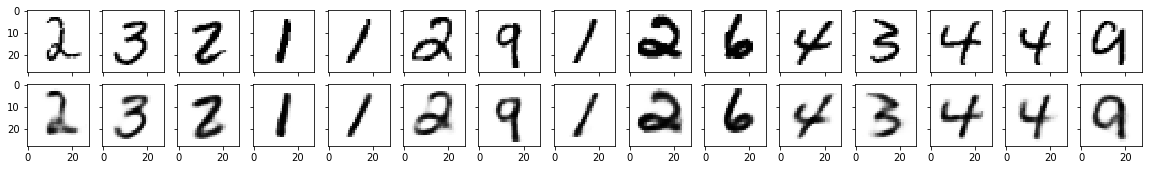

In [14]:
# Evaluation
%matplotlib inline
import matplotlib.pyplot as plt

## visualize ##

n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images,
                        sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]
decoded_images = decoded[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i].detach().to(torch.device('cpu'))
        ax[i].imshow(curr_img.view((image_width, image_width)), cmap='binary')

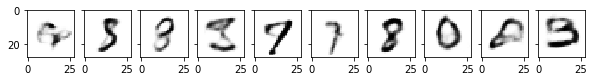

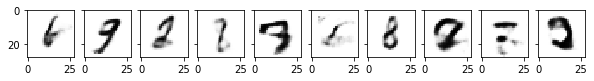

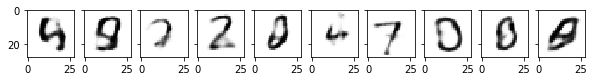

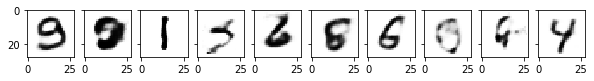

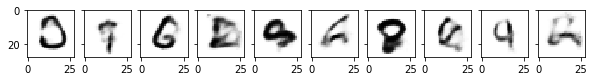

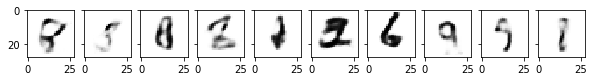

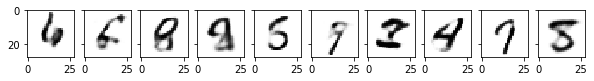

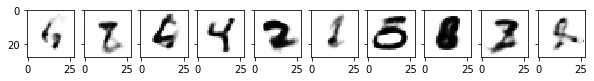

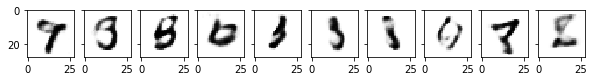

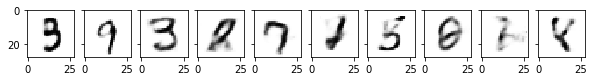

In [16]:
# generate new images
for i in range(10):
    n_images = 10
    rand_features = torch.randn(n_images, num_latent).to(device)
    new_images = model.decoder(rand_features)
    
    # visualize
    
    image_width = 28
    fig, axes = plt.subplots(nrows=1, ncols=n_images, figsize=(10, 2.5), sharey=True)
    decoded_images = new_images[:n_images]
    
    for ax, img, in zip(axes, decoded_images):
        curr_img = img.detach().to(torch.device('cpu'))
        ax.imshow(curr_img.view((image_width, image_width)), cmap='binary')
    plt.show()